还没进行统计处理

In [10]:
## z-score transform x
for i in range(X_train.shape[1]):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [13]:
aq_train = pd.read_csv("data/aq_train_data.csv")
meo_train = pd.read_csv("data/meo_train_data.csv")   
train_df = pd.concat([aq_train, meo_train], axis=1)

In [18]:
train_df.mean(axis=0, skipna=True).shape

(385,)

## 0. seq2seq Model
- 使用之前5天的数据，对之后48小时的空气质量进行预测，模型如下

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-19-seq2seq_model.png)
<caption><center> **Figure 1**: lstm model</center></caption>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

from utils.plot_util import plot_forecast_and_actual_example
from metrics.metrics import SMAPE_on_dataset
from seq2seq.seq2seq_data_util import generate_training_set, generate_dev_set
from seq2seq.multi_variable_seq2seq_model_parameters import build_graph

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

## Preprocessing

多变量版本

In [27]:
station_list = ['dongsi_aq','tiantan_aq','guanyuan_aq','wanshouxigong_aq','aotizhongxin_aq',
            'nongzhanguan_aq','wanliu_aq','beibuxinqu_aq','zhiwuyuan_aq','fengtaihuayuan_aq',
            'yungang_aq','gucheng_aq','fangshan_aq','daxing_aq','yizhuang_aq','tongzhou_aq',
            'shunyi_aq','pingchang_aq','mentougou_aq','pinggu_aq','huairou_aq','miyun_aq',
            'yanqin_aq','dingling_aq','badaling_aq','miyunshuiku_aq','donggaocun_aq',
            'yongledian_aq','yufa_aq','liulihe_aq','qianmen_aq','yongdingmennei_aq',
            'xizhimenbei_aq','nansanhuan_aq','dongsihuan_aq']            
X_aq_list = ["PM2.5","PM10","O3","CO","SO2","NO2"]  
y_aq_list = ["PM2.5","PM10","O3"]
X_meo_list = ["temperature","pressure","humidity","direction","speed/kph"]
use_day=True
pre_days=5
batch_size=32

少变量版本（测试）

In [2]:
station_list = ['aotizhongxin_aq']            
X_aq_list = ["PM2.5","PM10","O3","CO","SO2","NO2"]  
y_aq_list = ["PM2.5"]
X_meo_list = ["temperature","pressure","humidity","direction","speed/kph"]
use_day=True
pre_days=5
batch_size=32

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [3]:
test_x, test_y = generate_dev_set(station_list, X_aq_list, y_aq_list)

In [4]:
print(test_x.shape, test_y.shape)

(17, 120, 6) (17, 48, 1)


In [5]:
X_training_batch, y_training_batch = generate_training_set(station_list, X_aq_list, y_aq_list)

In [6]:
print(X_training_batch.shape, y_training_batch.shape)

(32, 120, 6) (32, 48, 1)


## Build the model and train the model 

In [11]:
input_seq_len = pre_days * 24
output_seq_len = 48
hidden_dim = 32
input_dim = 6
output_dim = 1
num_stacked_layers = 2

learning_rate=0.00001
lambda_l2_reg=0.003
GRADIENT_CLIPPING=2.5
total_iteractions = 200
KEEP_RATE = 0.5

In [12]:
rnn_model = build_graph(feed_previous=False, input_seq_len=input_seq_len, output_seq_len=output_seq_len, 
                hidden_dim=hidden_dim, input_dim=input_dim, output_dim=output_dim, num_stacked_layers=num_stacked_layers, 
                learning_rate=learning_rate, lambda_l2_reg=lambda_l2_reg, GRADIENT_CLIPPING=GRADIENT_CLIPPING)

In [13]:
train_losses = []
val_losses = []

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    losses = []
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_training_set(station_list, X_aq_list, y_aq_list)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t,:] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t,:] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        if i%10 == 0:
            print("loss after %d/%d iteractions : %.3f" %(i, total_iteractions, loss_t))
        losses.append(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./seq2seq/multi_variable_model_results/', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)

Training losses: 
loss after 0/200 iteractions : nan
loss after 10/200 iteractions : nan
loss after 20/200 iteractions : nan
loss after 30/200 iteractions : nan
loss after 40/200 iteractions : nan
loss after 50/200 iteractions : nan
loss after 60/200 iteractions : nan
loss after 70/200 iteractions : nan
loss after 80/200 iteractions : nan
loss after 90/200 iteractions : nan
loss after 100/200 iteractions : nan
loss after 110/200 iteractions : nan
loss after 120/200 iteractions : nan
loss after 130/200 iteractions : nan
loss after 140/200 iteractions : nan
loss after 150/200 iteractions : nan
loss after 160/200 iteractions : nan
loss after 170/200 iteractions : nan
loss after 180/200 iteractions : nan
loss after 190/200 iteractions : nan
Checkpoint saved at:  ./seq2seq/multi_variable_model_results/multivariate_ts_pollution_case


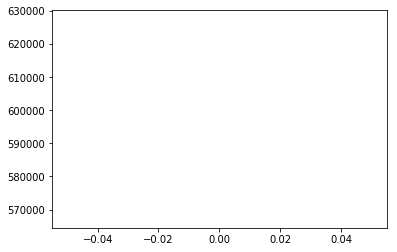

In [10]:
%matplotlib inline
plt.plot(losses)

## Inference on test 
Notice the batch prediction which is different to previous

In [18]:
# length of input signals
input_seq_len = 120
# length of output signals
output_seq_len = 48
# num of input signals
input_dim = 210
# num of output signals
output_dim = 105

In [19]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./seq2seq/multi_variable_model_results/', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./seq2seq/multi_variable_model_results/multivariate_ts_pollution_case
Test mse is:  3.2276583573759807


In [20]:
print("Shape of predictions is ",final_preds.shape)

Shape of predictions is  (576, 48, 105)


### Example of many featutres

In [21]:
print(output_features)

['zhiwuyuan_aq_PM2.5', 'zhiwuyuan_aq_PM10', 'zhiwuyuan_aq_O3', 'guanyuan_aq_PM2.5', 'guanyuan_aq_PM10', 'guanyuan_aq_O3', 'pinggu_aq_PM2.5', 'pinggu_aq_PM10', 'pinggu_aq_O3', 'yufa_aq_PM2.5', 'yufa_aq_PM10', 'yufa_aq_O3', 'miyunshuiku_aq_PM2.5', 'miyunshuiku_aq_PM10', 'miyunshuiku_aq_O3', 'tiantan_aq_PM2.5', 'tiantan_aq_PM10', 'tiantan_aq_O3', 'miyun_aq_PM2.5', 'miyun_aq_PM10', 'miyun_aq_O3', 'gucheng_aq_PM2.5', 'gucheng_aq_PM10', 'gucheng_aq_O3', 'tongzhou_aq_PM2.5', 'tongzhou_aq_PM10', 'tongzhou_aq_O3', 'nongzhanguan_aq_PM2.5', 'nongzhanguan_aq_PM10', 'nongzhanguan_aq_O3', 'badaling_aq_PM2.5', 'badaling_aq_PM10', 'badaling_aq_O3', 'fengtaihuayuan_aq_PM2.5', 'fengtaihuayuan_aq_PM10', 'fengtaihuayuan_aq_O3', 'shunyi_aq_PM2.5', 'shunyi_aq_PM10', 'shunyi_aq_O3', 'wanshouxigong_aq_PM2.5', 'wanshouxigong_aq_PM10', 'wanshouxigong_aq_O3', 'yanqin_aq_PM2.5', 'yanqin_aq_PM10', 'yanqin_aq_O3', 'liulihe_aq_PM2.5', 'liulihe_aq_PM10', 'liulihe_aq_O3', 'aotizhongxin_aq_PM2.5', 'aotizhongxin_aq_PM10

/home/cvdev/tf/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


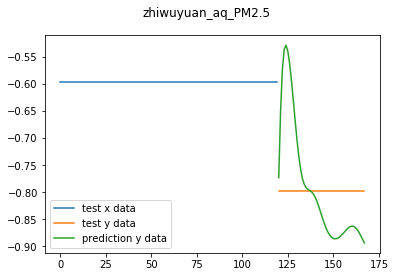

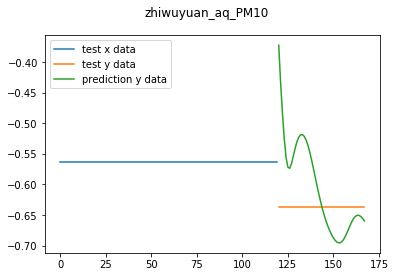

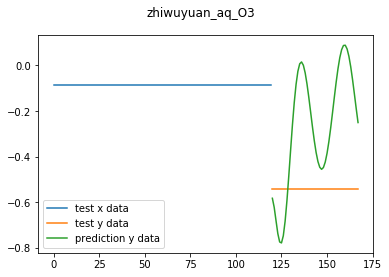

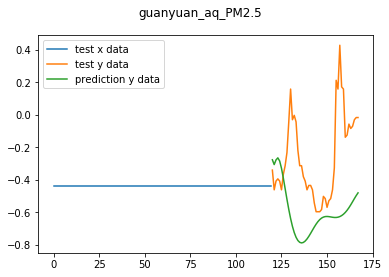

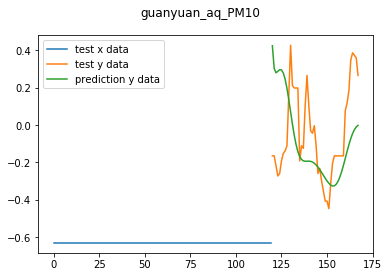

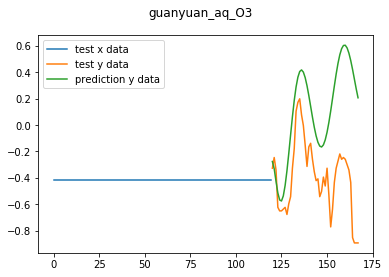

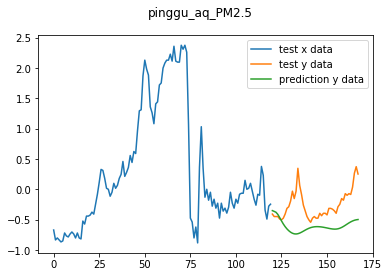

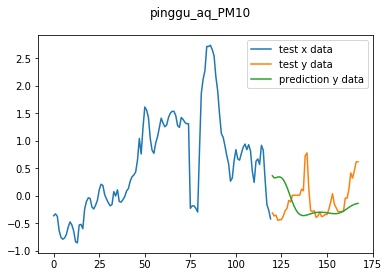

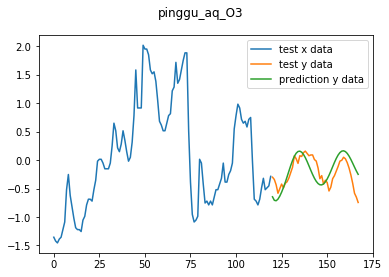

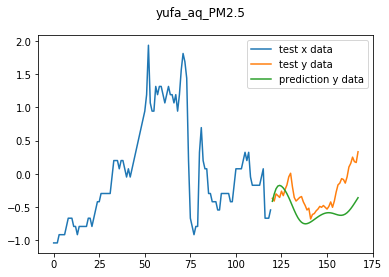

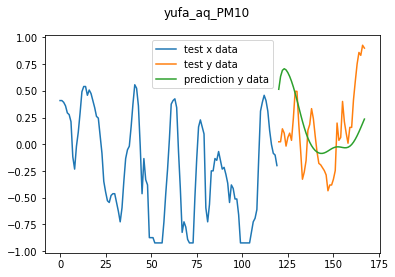

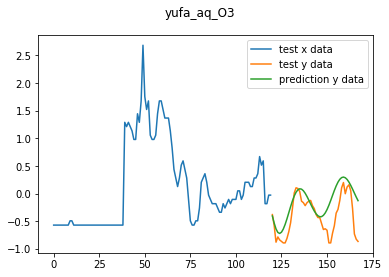

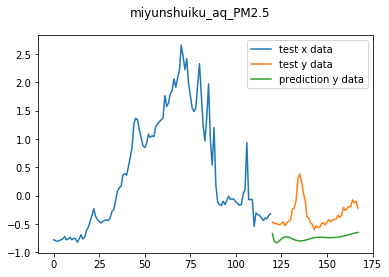

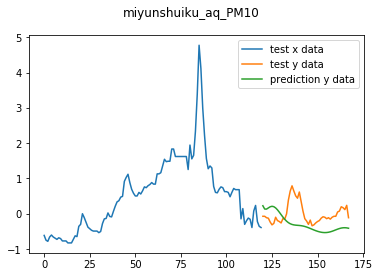

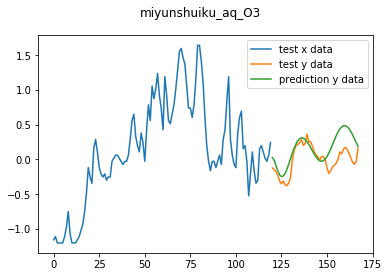

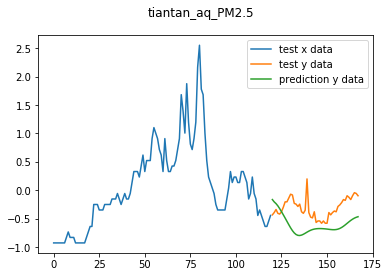

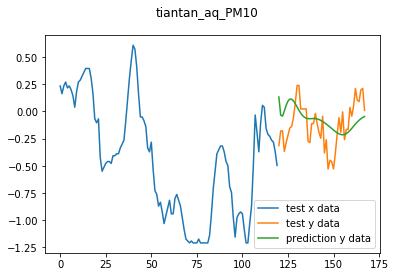

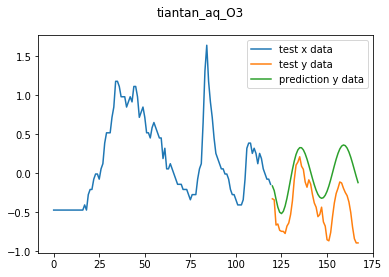

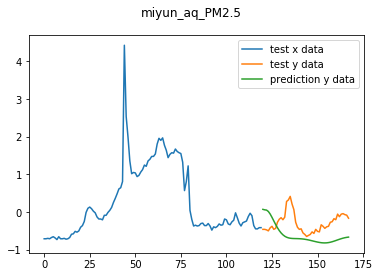

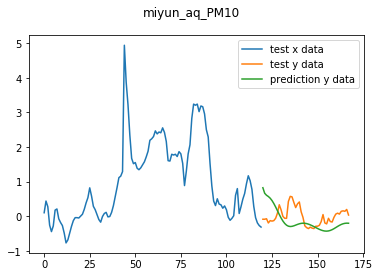

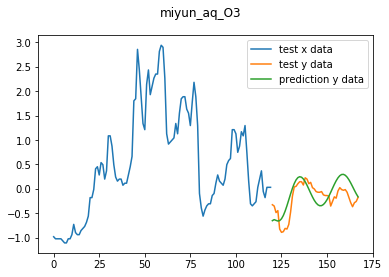

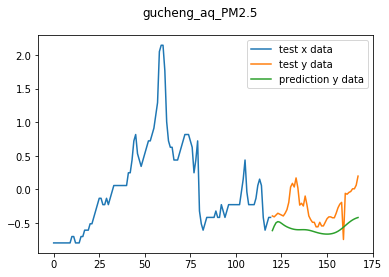

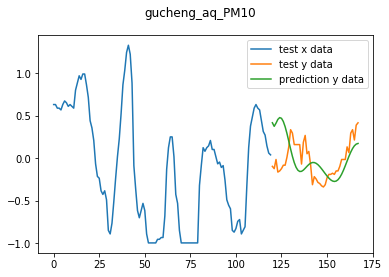

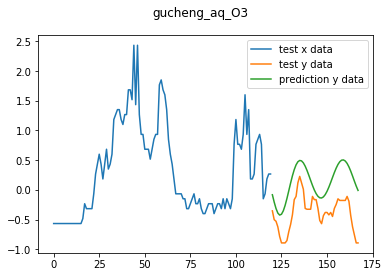

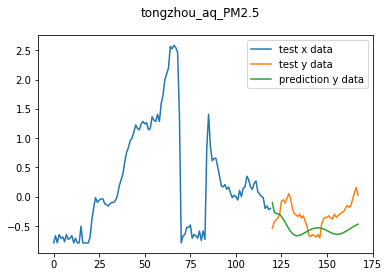

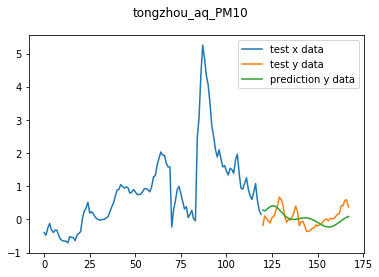

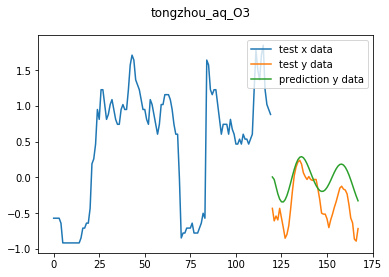

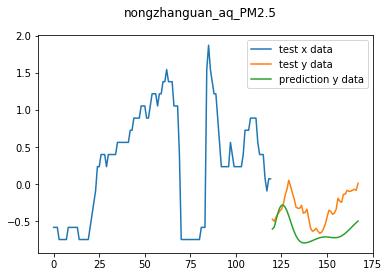

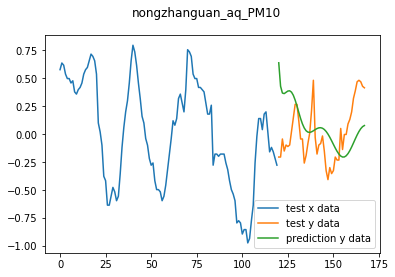

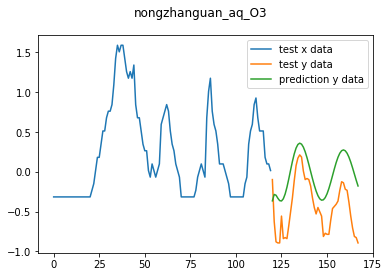

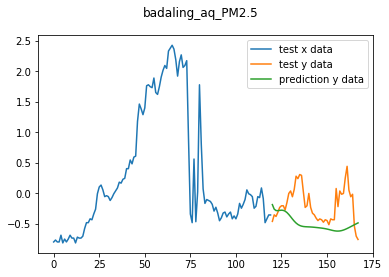

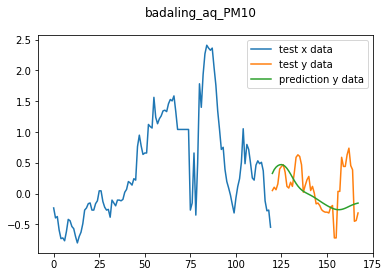

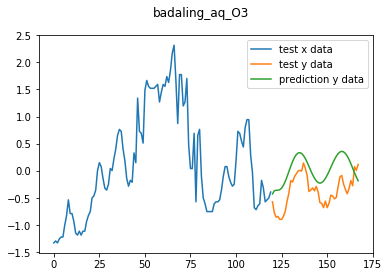

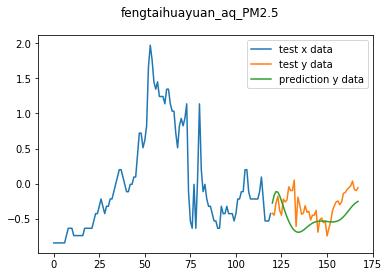

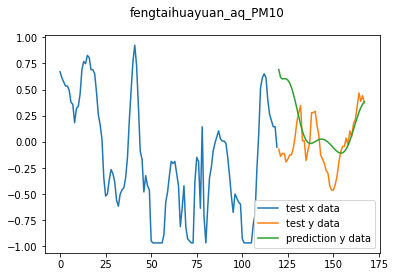

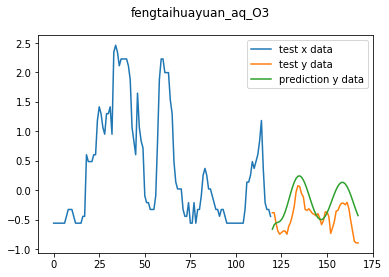

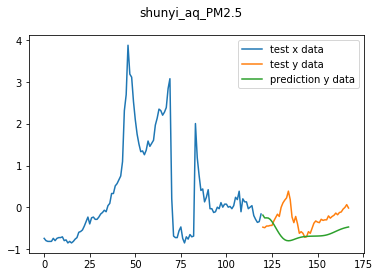

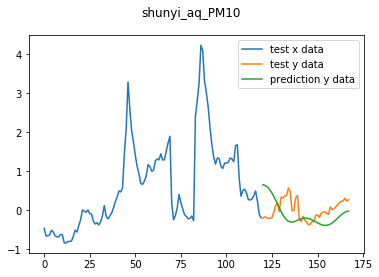

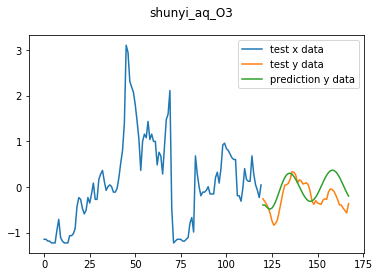

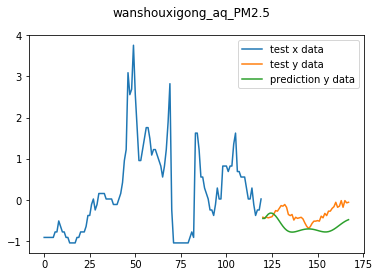

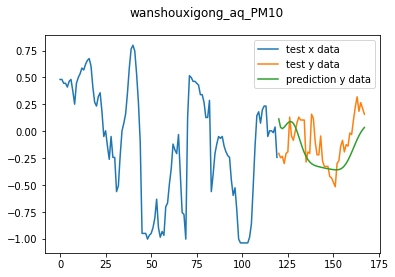

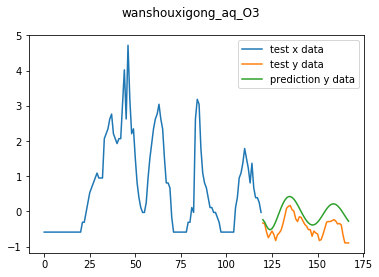

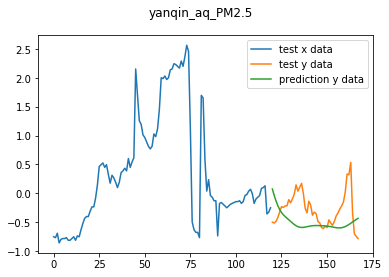

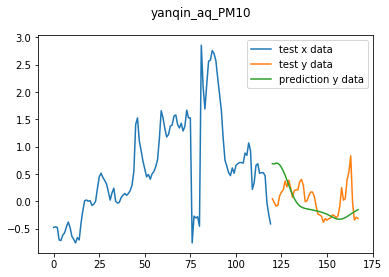

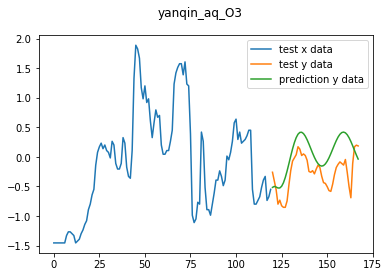

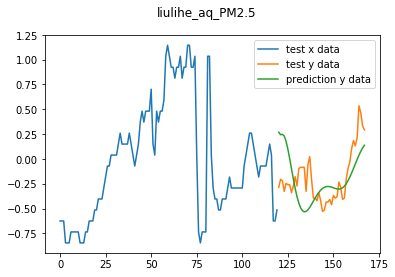

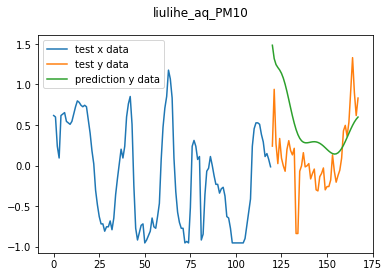

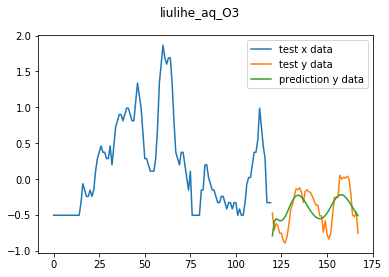

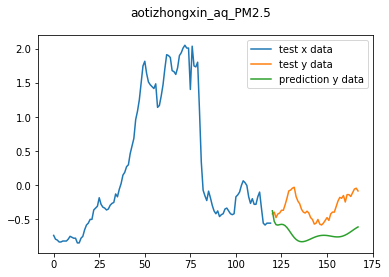

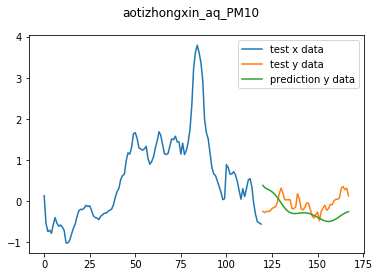

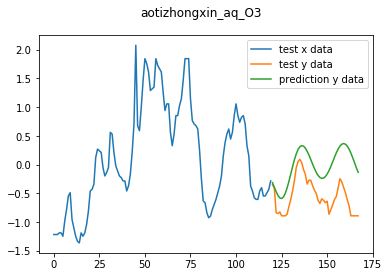

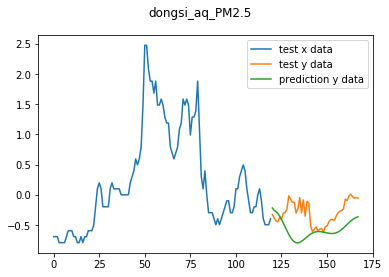

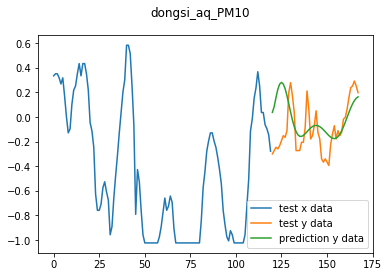

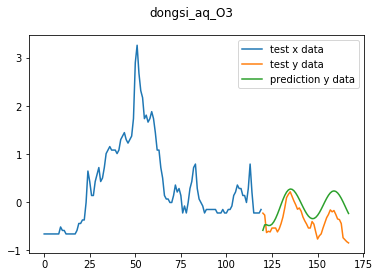

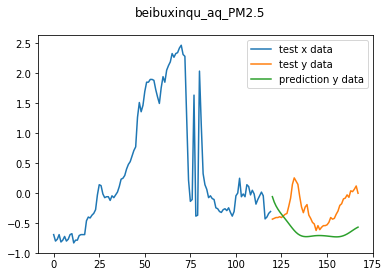

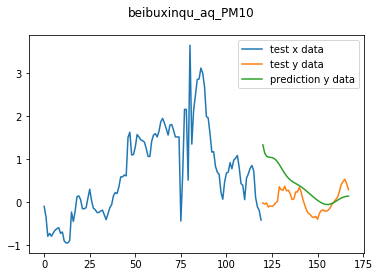

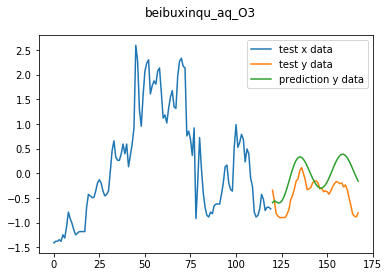

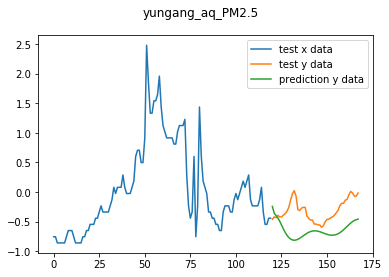

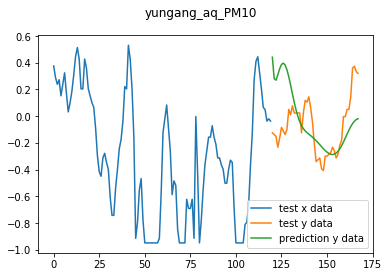

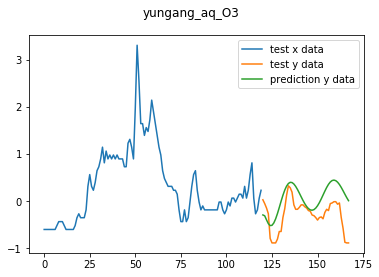

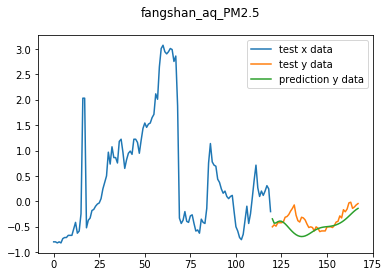

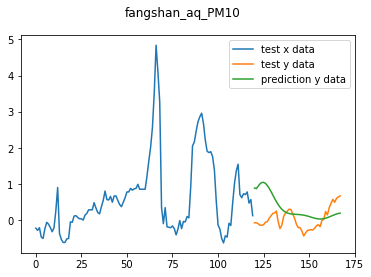

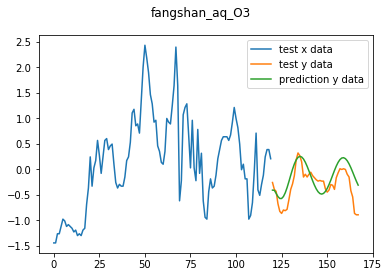

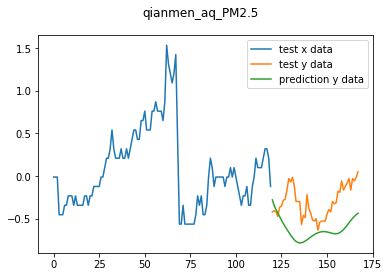

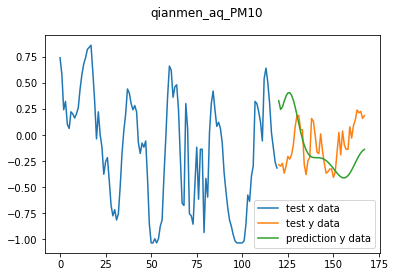

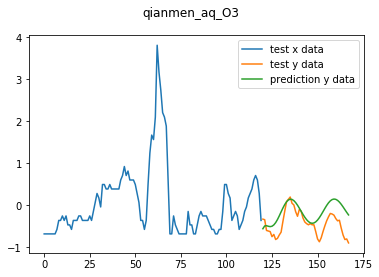

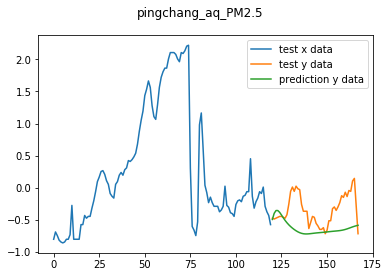

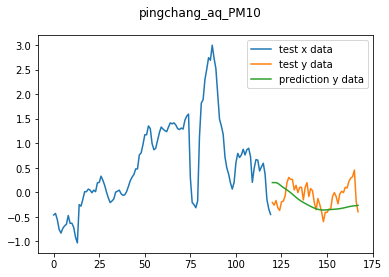

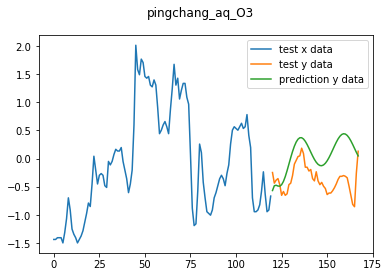

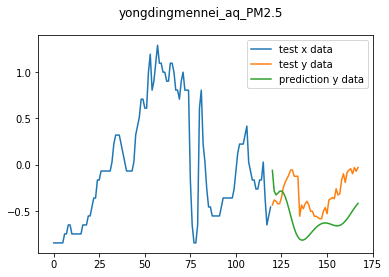

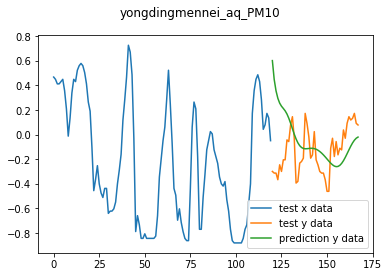

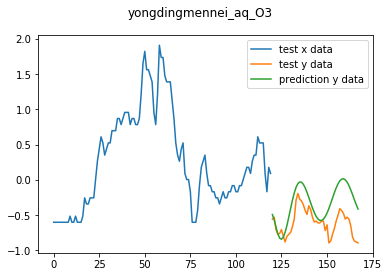

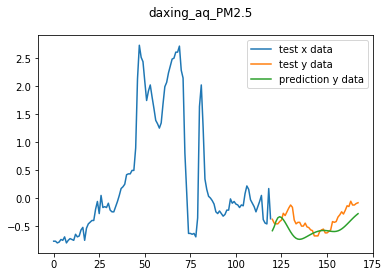

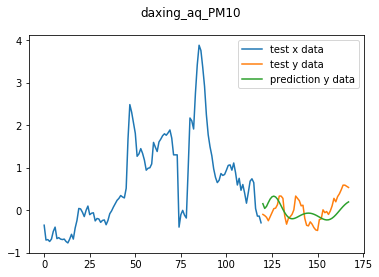

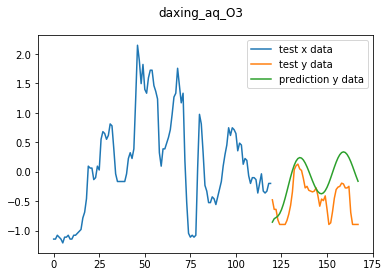

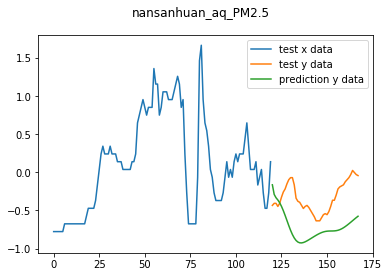

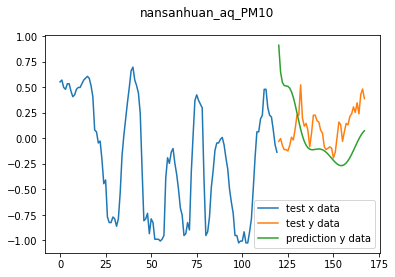

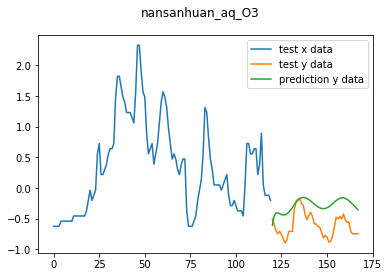

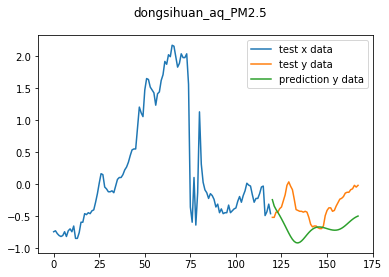

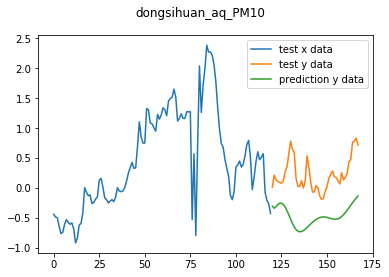

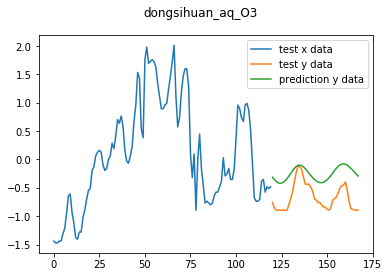

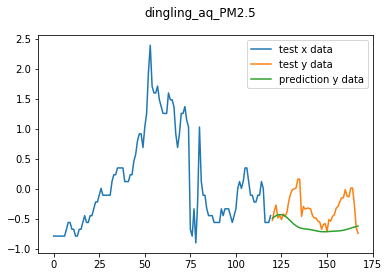

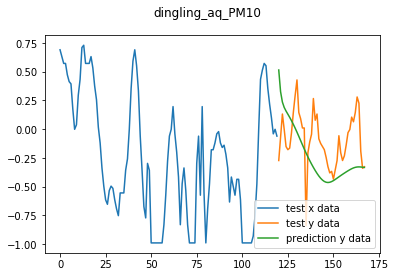

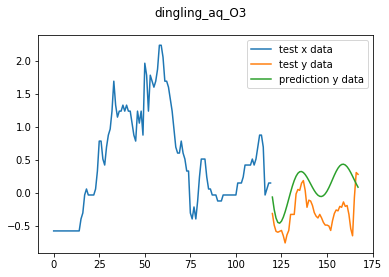

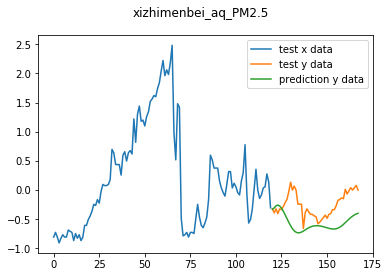

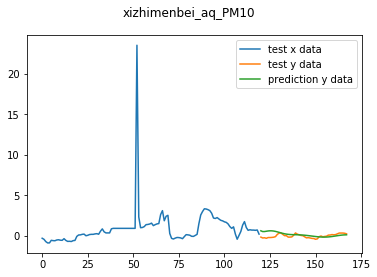

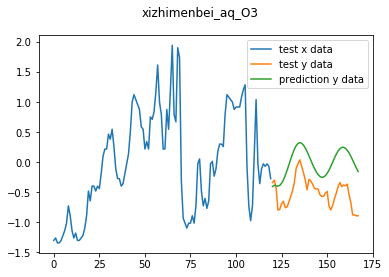

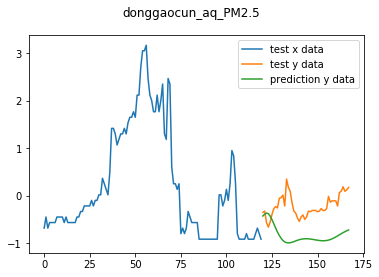

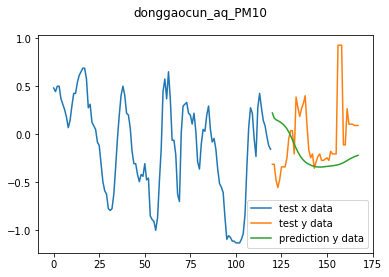

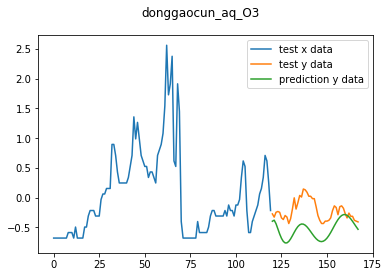

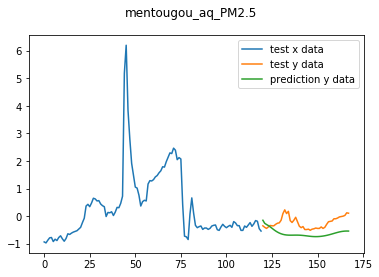

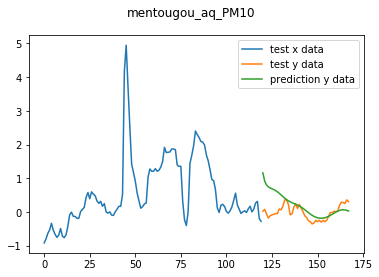

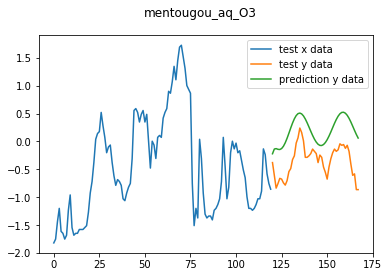

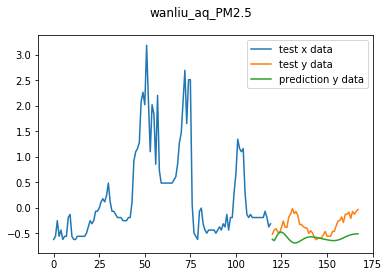

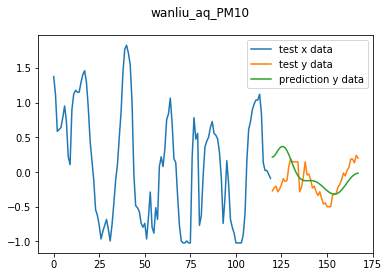

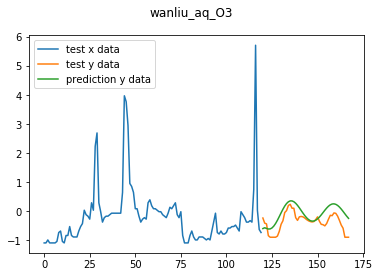

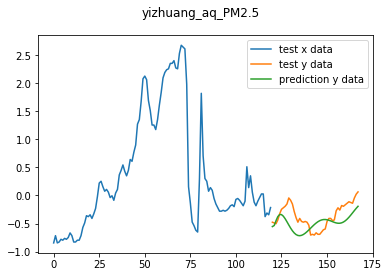

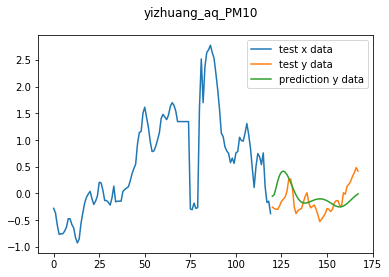

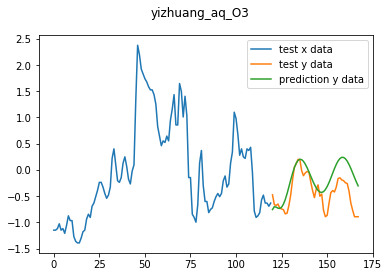

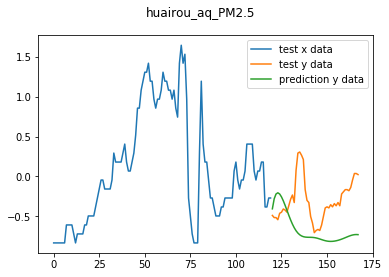

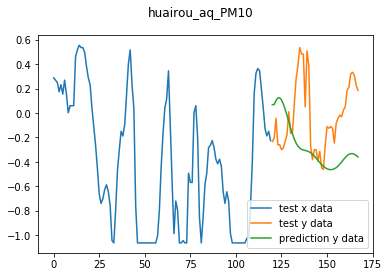

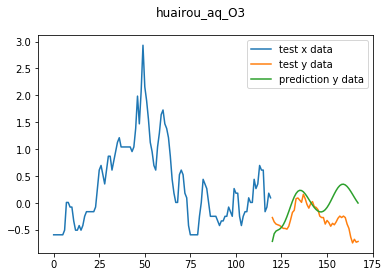

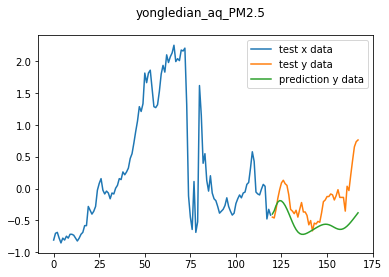

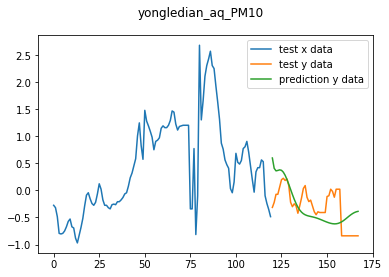

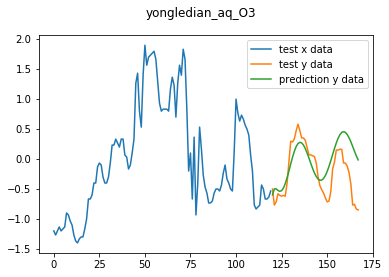

In [22]:
# 预测值普遍在 O3 上表现较好，另外两个参数　PM2.5 和　PM10 上通常捕捉不到高频分量
for i in range(len(output_features)):
    plot_forecast_and_actual_example(test_x, test_y, final_preds, output_features, index=0, feature_index=i)

### 某个特征在整个dev数据集时间跨度上的表现

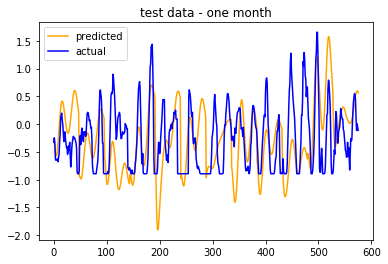

In [24]:
## remove duplicate hours and concatenate into one long array
feature_index = 5
test_y_expand = np.concatenate([test_y[i,:,feature_index] for i in range(0, test_y.shape[0], output_seq_len)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i,:,feature_index] for i in range(0, final_preds.shape[0], output_seq_len)], axis = 0)
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()

### Smapes of all features

In [25]:
aver_smapes, smapes_of_features = SMAPE_on_dataset(test_y, final_preds, output_features, y_mean, y_std, 24)

In [26]:
# smape value on all features
smapes_of_features

{'aotizhongxin_aq_O3': 0.9033747953147865,
 'aotizhongxin_aq_PM10': 0.5718946270291979,
 'aotizhongxin_aq_PM2.5': 0.7457085716015857,
 'badaling_aq_O3': 0.8041749469633239,
 'badaling_aq_PM10': 0.5564821160654873,
 'badaling_aq_PM2.5': 0.7049697537670129,
 'beibuxinqu_aq_O3': 1.0420253121274101,
 'beibuxinqu_aq_PM10': 0.5902215043625896,
 'beibuxinqu_aq_PM2.5': 0.7866312659997835,
 'daxing_aq_O3': 0.9610806103375031,
 'daxing_aq_PM10': 0.5462000516832216,
 'daxing_aq_PM2.5': 0.7143493858469224,
 'dingling_aq_O3': 0.6047706707798631,
 'dingling_aq_PM10': 0.5550950702163014,
 'dingling_aq_PM2.5': 0.8088193923510388,
 'donggaocun_aq_O3': 0.6080458117167155,
 'donggaocun_aq_PM10': 0.5778800265374652,
 'donggaocun_aq_PM2.5': 0.705846603198253,
 'dongsi_aq_O3': 0.9123188588253756,
 'dongsi_aq_PM10': 0.5068988974290636,
 'dongsi_aq_PM2.5': 0.6625081860635338,
 'dongsihuan_aq_O3': 1.0957649180244609,
 'dongsihuan_aq_PM10': 0.7569836099165018,
 'dongsihuan_aq_PM2.5': 0.7288406831512004,
 'fangs

In [27]:
print("The average smape on all features in the dev set is : ",aver_smapes)

The average smape on all features in the dev set is :  0.7111534524687351


# ChangeLog
- 0419 
    - 修正了 SMAPE 计算方法，将 正则化的因素考虑进去
    - 整理了多变量 seq2seq 模型，验证集上 SMAPE 为 0.709  